# Imports

In [1]:
# Libraries

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# others
import pandas as pd
import time
import numpy as np
import random
import os

from PIL import Image
import cv2
from IPython.display import display
from tqdm import tqdm_notebook
import copy # To copy later our best model

# Chargement données

## Config

In [40]:
# Emplacement
path = "C:/Users/Nina/Documents/GitHub/AVR23---BDS---Radio-Pulm/data"     ### A MODIFIER EN LOCAL !!
dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]
ID_DIR = 7

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

# Paramètres
SIZE = (256,256)
RATIO_VAL = 0.2 
BATCH_SIZE = 42
NB_EPOCHS = 5

## Dataframe

In [32]:

# Création des 4 listes de noms d'images
normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/images') if fn.endswith('.png')]

# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []
for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_paths)) 
"""Le chiffre '6' est à changer en fonction de la longueur du path, le but est de recupérer les termes "nomrals", "covid",... """


# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df = df.drop(['nameLabel'], axis=1)
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

df = df[0:400]
df.head()

,filepath,label
0,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,3
1,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,1
2,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,0
3,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,2
4,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,1


## Itérateurs d'images

In [41]:
# Séparation dataframe en ensemble entraiement et validation
train, test = train_test_split(df, test_size=RATIO_VAL, shuffle = False)



# Création des itérateurs qui chargeront des lots d'images
train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Initialisation du image generator de train
print(f"Number of rows in train set: {len(train)}")
train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = SIZE, #Resize
                                                           batch_size = BATCH_SIZE,
                                                           color_mode = "grayscale") #Niveau de gris

# Initialisation du image generator de test
print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         color_mode = "grayscale") #Niveau de gris

Number of rows in train set: 320
Found 320 validated image filenames belonging to 4 classes.
Number of rows in test set: 80
Found 80 validated image filenames belonging to 4 classes.


# Modèle

In [42]:
# Instanciation modèle séquentiel
lenet = Sequential()

# Ajout des différentes couches
lenet.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
lenet.add(MaxPooling2D(pool_size = (2,2)))

lenet.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
lenet.add(MaxPooling2D(pool_size = (2,2)))

lenet.add(Flatten())
lenet.add(Dropout(rate = 0.2))

lenet.add(Dense(units = 128, activation = "relu"))
lenet.add(Dense(units = 4, activation = "softmax"))

# Compilation
lenet.compile(loss = "sparse_categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"]) #LR default 10-3

In [43]:
# Entrainement modèle
train_size = train_generator.samples
test_size = test_generator.samples

history = lenet.fit_generator(train_generator,
                              epochs = NB_EPOCHS,
                              steps_per_epoch = train_size // BATCH_SIZE,
                              validation_data = test_generator,
                              validation_steps = test_size // BATCH_SIZE)

C:\Users\Nina\AppData\Local\Temp\ipykernel_16824\4147302214.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = lenet.fit_generator(train_generator,


Epoch 1/5
7/7 [==============================] - 52s 6s/step - loss: 418.5654 - accuracy: 0.3849 - val_loss: 2.3172 - val_accuracy: 0.3333
Epoch 2/5
7/7 [==============================] - 30s 3s/step - loss: 1.4685 - accuracy: 0.4694 - val_loss: 1.2368 - val_accuracy: 0.4524
Epoch 3/5
7/7 [==============================] - 27s 3s/step - loss: 0.7765 - accuracy: 0.7230 - val_loss: 1.0877 - val_accuracy: 0.5714
Epoch 4/5
7/7 [==============================] - 32s 4s/step - loss: 0.4962 - accuracy: 0.8489 - val_loss: 1.3213 - val_accuracy: 0.5238
Epoch 5/5
7/7 [==============================] - 27s 3s/step - loss: 0.3240 - accuracy: 0.9065 - val_loss: 0.8176 - val_accuracy: 0.7381


# Evaluation

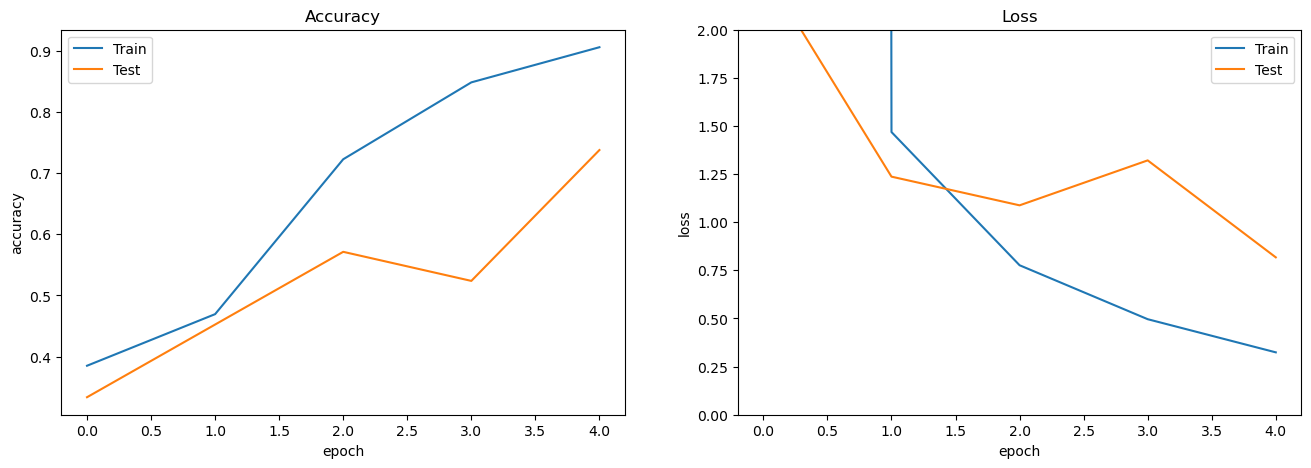

In [51]:
# Courbes d'accuracy et de perte
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")

plt.subplot(122)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,2)
plt.title("Loss")
plt.show();

In [52]:
# Calcul des prédictions (probabilités)
test_generator.reset()
test_pred_lenet = lenet.predict(test_generator, verbose = 1 )

2/2 [==============================] - 9s 1s/step


In [53]:
# Récupération des classes à partir des probabilités
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test["label"].astype("int"), test_pred_lenet_class))

[[15  4  2 16]
 [ 7  4  2  4]
 [ 2  0  0  2]
 [12  3  0  7]]


In [54]:
print(classification_report(test["label"].astype("int"), test_pred_lenet_class))

              precision    recall  f1-score   support

           0       0.42      0.41      0.41        37
           1       0.36      0.24      0.29        17
           2       0.00      0.00      0.00         4
           3       0.24      0.32      0.27        22

    accuracy                           0.33        80
   macro avg       0.26      0.24      0.24        80
weighted avg       0.34      0.33      0.33        80

